# **Automated Classification of Customer Complaints for Scalable Support Ticket Routing**

## Project Description
This project aims to build a machine learning pipeline that automatically classifies unstructured customer complaints into predefined issue categories such as *Technical Issue*, *Billing & Payment*, or *Account & Login Problems*. By mapping free-text complaints to structured labels, the system enhances support efficiency through faster triaging, accurate routing, and scalable processing of high-volume tickets. The pipeline leverages text preprocessing, feature extraction, and supervised learning to achieve robust classification performance.

## 1.1 DataSet Overview

In [5]:
import pandas as pd

df = pd.read_csv('ProjectData.csv')
# Print the first few rows of the DataFrame
print(df.head())  

                                  Customer Statement  Message Length  \
0  The software shutdown unexpectedly while I was...              11   
1  Software force close happens every time I open...              10   
2  It triggers a software quit before I can even ...              11   
3  I edited the file but nothing saved. A classic...              14   
4  Submission keeps failing with a software form ...               9   

  Platform Type Submission Channel  Response Time (sec)  \
0           Web              Phone               290.39   
1    Mobile App              Email               276.23   
2           Web          Live Chat               297.84   
3    Mobile App              Phone                50.41   
4       Desktop              Phone               144.40   

   Resolution Time (min)  Issue Category  
0                  95.54  Software Issue  
1                 102.07  Software Issue  
2                 119.25  Software Issue  
3                  70.43  Software Issue

In [6]:
# Number of customer statements: Get the number of rows in the DataFrame
num_rows = df.shape[0]
print(f"Number of customer statements: {num_rows}")

Number of customer statements: 150


In [7]:
import random
# print a random customer statement based on an ID using Iloc function
# Generate a random index within the range of 0 to number of rows
random_index = random.randint(0, num_rows - 1)

# Get a row using iloc
random_customer_statement = df.iloc[random_index]

# Print the details of the random customer statement 
random_customer_statement

Customer Statement       Reset link takes me to an error page.
Message Length                                               8
Platform Type                                              Web
Submission Channel                                       Email
Response Time (sec)                                      66.34
Resolution Time (min)                                    21.67
Issue Category                           Account & Login Issue
Name: 112, dtype: object

## 1.2 Data Visualization – Distribution of Customer Complaints

### Objective:
Understand how customer complaints are distributed across the five predefined issue categories.

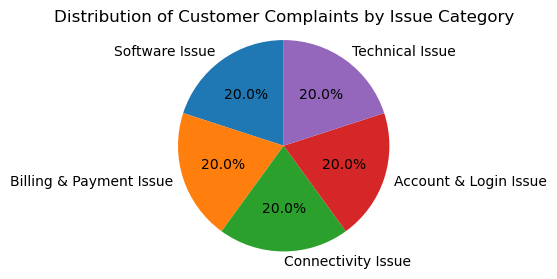

In [8]:
import matplotlib.pyplot as plt
# Count complaints in each issue category
issue_counts = df['Issue Category'].value_counts()

# Plot the distribution as a pie chart
plt.figure(figsize=(3, 3))
plt.pie(issue_counts, labels=issue_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Customer Complaints by Issue Category')
plt.axis('equal')  # Ensure pie chart is a circle
plt.show()

### Observation:
This visualization shows that all five issue categories have an equal number of complaints. There is no apparent class imbalance or category bias in the dataset, which ensures a fair and unbiased learning process for the classification model.


## 1.3 Analyze Most Frequently Used Words in Complaints by Category

### Objective:
Use word clouds to explore the most frequent terms customers use when describing issues in different categories.

In [9]:
from wordcloud import WordCloud

# Helper function to generate word clouds per category
def generate_wordclouds(complaints, issue_type):
    """
    Displays a word cloud for a specific issue category based on customer statements.
    """
    text = " ".join(complaints.astype(str).str.lower())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {issue_type} Complaints')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


#### Word Cloud: Billing & Payment Issue

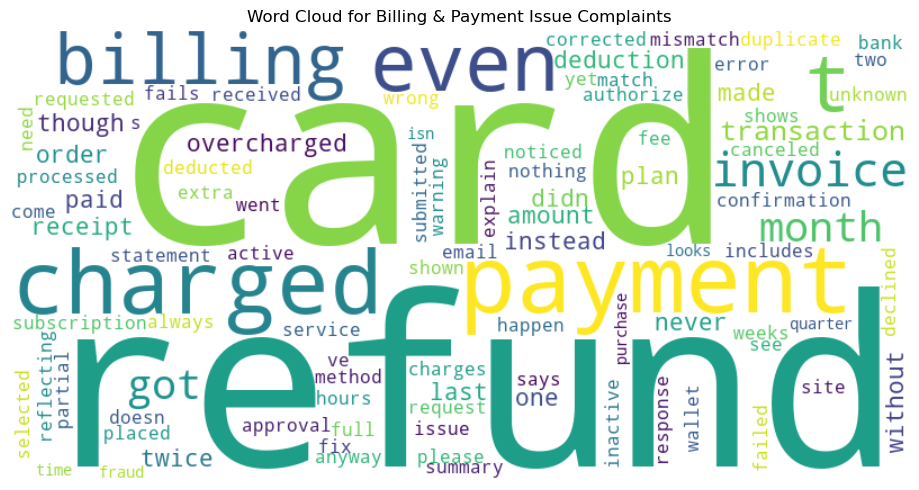

Number of complaints analyzed: 30


In [10]:
billing_complaints = df[df['Issue Category'] == "Billing & Payment Issue"]['Customer Statement']
generate_wordclouds(billing_complaints, "Billing & Payment Issue")
print(f"Number of complaints analyzed: {len(billing_complaints)}")

### Word Cloud: Account & Login Issue

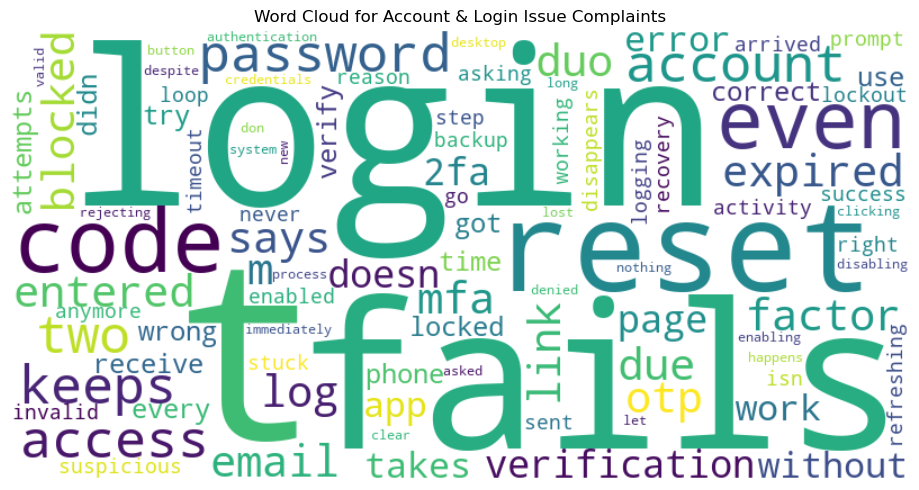

Number of complaints analyzed: 30


In [11]:
account_complaints = df[df['Issue Category'] == "Account & Login Issue"]['Customer Statement']
generate_wordclouds(account_complaints, "Account & Login Issue")
print(f"Number of complaints analyzed: {len(account_complaints)}")

### Word Cloud: Connectivity Issue

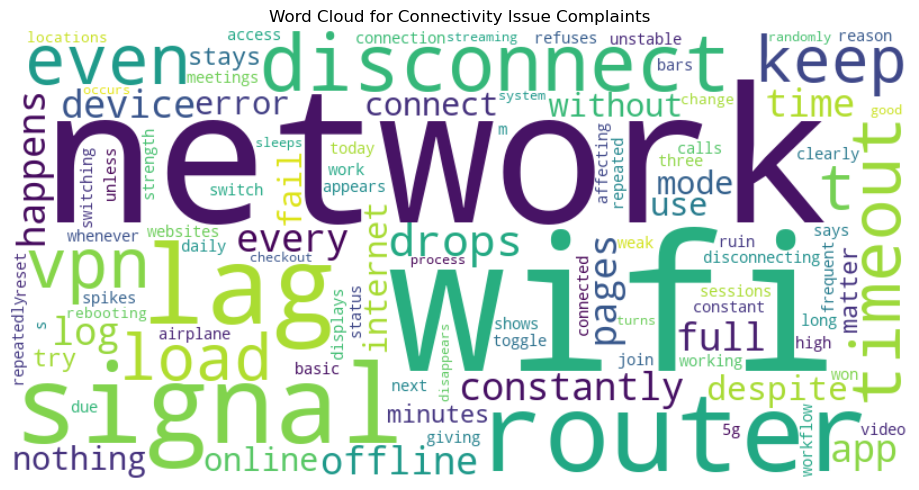

Number of complaints analyzed: 30


In [12]:
connectivity_complaints = df[df['Issue Category'] == "Connectivity Issue"]['Customer Statement']
generate_wordclouds(connectivity_complaints, "Connectivity Issue")
print(f"Number of complaints analyzed: {len(connectivity_complaints)}")

### Word Cloud: Software Issue

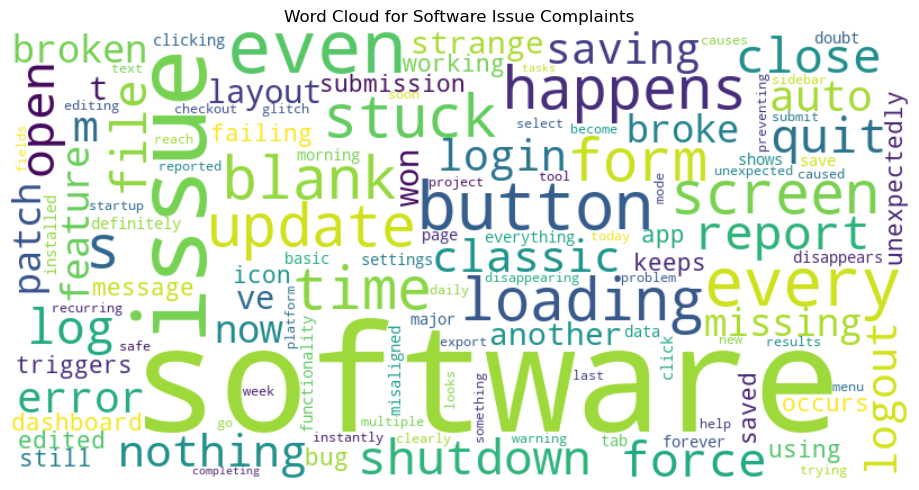

Number of complaints analyzed: 30


In [13]:
software_complaints = df[df['Issue Category'] == "Software Issue"]['Customer Statement']
generate_wordclouds(software_complaints, "Software Issue")
print(f"Number of complaints analyzed: {len(software_complaints)}")


### Word Cloud: Technical Issue

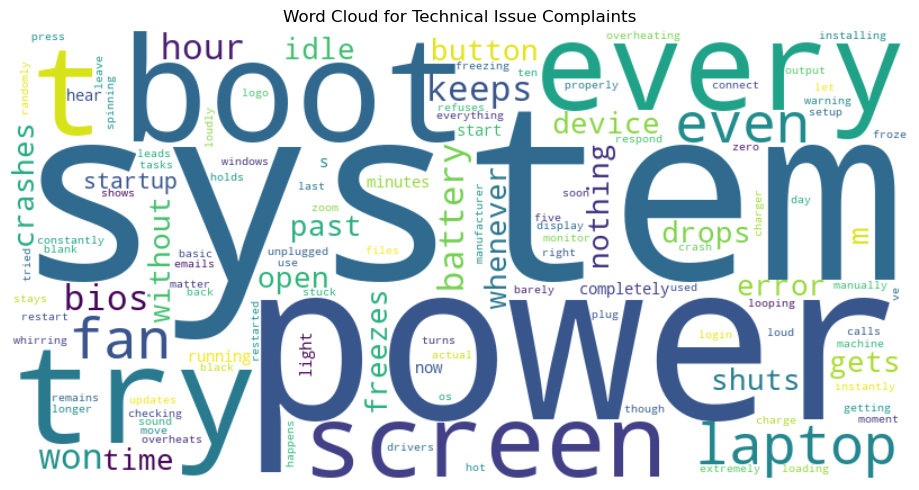

Number of complaints analyzed: 30


In [14]:
technical_complaints = df[df['Issue Category'] == "Technical Issue"]['Customer Statement']
generate_wordclouds(technical_complaints, "Technical Issue")
print(f"Number of complaints analyzed: {len(technical_complaints)}")


## 2 Data Preprocessing

## 2.1 Text Normalization

### Objective:
Transform raw customer complaint text into a cleaner and more structured format suitable for machine learning models. This includes:
- Lowercasing, expanding contractions, and cleaning punctuation
- Tokenizing, removing stopwords, and stemming

#### Step 1: Remove mentions, email address, HTML tags not needed in customer complaints.

In [15]:
import re

def process_complaint_text(text, verbose=False):
    """
    Step 1: Basic Text Cleanup for Customer Complaints
    
    Cleans raw customer complaint statements by removing:
    - Non-informative symbols and formatting artifacts
    - URLs and special characters
    - Extra whitespace

    Args:
        text (str): The original free-form complaint text
        verbose (bool): If True, prints before/after results

    Returns:
        str: Cleaned text string
    """
    if verbose:
        print("Step 1: Basic Cleanup (Removing URLs, special characters, extra spaces)")
        print(f"\tOriginal: {text}")
    
    # Remove URLs
    text = re.sub(r'(http|https)://\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove numeric-only tokens (like long order IDs, phone numbers, etc.)
    text = re.sub(r'\b\d{6,}\b', '', text)
    
    # Remove HTML-like tags (rare but may exist in logs or escalations)
    text = re.sub(r'<.*?>', '', text)
    
    # Replace non-alphanumeric characters with space (retain words & numbers)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    if verbose:
        print(f"\tCleaned: {text}")
    
    return text


#### Step 2: Word-level cleaning

In [16]:
import contractions
import emoji
#  Step 2: Word-level cleaning
def process_word_level(text, verbose=False):
    if verbose:
        print("Step 2: Word Normalization (lowercasing, contraction handling, emoji removal)")
        print(f"\tBefore: {text}")
    
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # limit repeated characters
    text = re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", text)
    text = emoji.demojize(text)

    if verbose:
        print(f"\tAfter: {text}")
    
    return text


#### Step 3: Tokenization

In [17]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
# Step 3: Tokenization
def tokenize(text, verbose=False):
    if verbose:
        print("Step 3: Tokenization")
        print(f"\tText: {text}")
    
    tokens = word_tokenize(text)
    
    if verbose:
        print(f"\tTokens: {tokens}")
    
    return tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Step 4: Remove stopwords & punctuation

In [18]:
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
# Step 4: Remove stopwords & punctuation
def clean_tokens(tokens, keep_punct=False, keep_alnum=False, keep_stop=False, verbose=False):
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')  # Retain 'not' for sentiment or negation

    if verbose:
        print("Step 4: Removing stopwords, punctuation, and non-alpha tokens")
        print(f"\tBefore: {tokens}")
    
    if not keep_punct:
        tokens = [t for t in tokens if t not in string.punctuation]
    if not keep_alnum:
        tokens = [t for t in tokens if t.isalpha()]
    if not keep_stop:
        tokens = [t for t in tokens if t not in stop_words]

    if verbose:
        print(f"\tAfter: {tokens}")
    
    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Step 5: Lemmatization 

In [19]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
# Step 5: Lemmatization
def lemmatize_tokens(tokens, verbose=False):
    lemmatizer = WordNetLemmatizer()
    
    if verbose:
        print("Step 5: Lemmatizing")
        print(f"\tOriginal Tokens: {tokens}")
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if verbose:
        print(f"\tLemmatized Tokens: {tokens}")
    
    return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [20]:
def preprocess_single_statement(text, verbose=False):
    text = process_complaint_text(text, verbose)
    text = process_word_level(text, verbose)
    tokens = tokenize(text, verbose)
    tokens = clean_tokens(tokens, verbose=verbose)
    tokens = lemmatize_tokens(tokens, verbose=verbose)
    return tokens

In [21]:
def preprocess_dataframe(df, verbose=False):
    df = df.copy()
    df['tokens'] = df['Customer Statement'].apply(lambda x: preprocess_single_statement(x, verbose))
    return df


In [22]:
import random


# Get the unique issue categories
issue_categories = df['Issue Category'].unique()
# Loop through each issue category and process one random complaint
for category in issue_categories:
    # Filter the DataFrame for the current category
    category_df = df[df['Issue Category'] == category]
    
    # Skip if no complaints in this category
    if category_df.empty:
        continue

    # Pick a random index within the filtered DataFrame
    idx = random.randint(0, len(category_df) - 1)
    row = category_df.iloc[idx]
    text = row['Customer Statement']

    print(f"\n--- {category} ---")
    print(f"\nOriginal Complaint (Row {row.name}):\n{text}\n")
    
    # Process and print cleaned version
    cleaned = preprocess_single_statement(text, verbose=True)
    print(f"Processed Tokens: {cleaned}")
    print("-" * 60)


--- Software Issue ---

Original Complaint (Row 16):
Software force close happens even in safe mode.

Step 1: Basic Cleanup (Removing URLs, special characters, extra spaces)
	Original: Software force close happens even in safe mode.
	Cleaned: Software force close happens even in safe mode
Step 2: Word Normalization (lowercasing, contraction handling, emoji removal)
	Before: Software force close happens even in safe mode
	After: software force close happens even in safe mode
Step 3: Tokenization
	Text: software force close happens even in safe mode
	Tokens: ['software', 'force', 'close', 'happens', 'even', 'in', 'safe', 'mode']
Step 4: Removing stopwords, punctuation, and non-alpha tokens
	Before: ['software', 'force', 'close', 'happens', 'even', 'in', 'safe', 'mode']
	After: ['software', 'force', 'close', 'happens', 'even', 'safe', 'mode']
Step 5: Lemmatizing
	Original Tokens: ['software', 'force', 'close', 'happens', 'even', 'safe', 'mode']
	Lemmatized Tokens: ['software', 'force', '

## 3. Text Vectorization

### Objective:
Convert the cleaned, tokenized customer complaint text into numerical format so that machine learning models can process it.
1. Bag of Words (BoW)
2. TF-IDF (Term Frequency-Inverse Document Frequency)

We'll use the `tokens` column as our feature and the `Issue Category` column as our classification target.

In [23]:
# Step 1: Preprocess and save the result
preprocessed_df = preprocess_dataframe(df, verbose=False)

# Step 2: Now safely extract tokens and labels
X = preprocessed_df["tokens"].tolist()
y = preprocessed_df["Issue Category"].tolist()

unique_labels = set(y)
print(f"Issue Categories:\n{unique_labels}\n")

# Show unique tokenized complaints (flattened as strings for uniqueness)
unique_complaints = set([" ".join(tokens) for tokens in X])
print(f"Number of Unique Tokenized Complaints: {len(unique_complaints)}")
print(f"Unique Complaints:\n{list(unique_complaints)[:10]}")


Issue Categories:
{'Connectivity Issue', 'Account & Login Issue', 'Software Issue', 'Billing & Payment Issue', 'Technical Issue'}

Number of Unique Tokenized Complaints: 150
Unique Complaints:
['matter try system keep freezing every hour', 'unplugged battery drop five minute', 'entered right code say invalid', 'access denied despite valid credential', 'log switching wifi network', 'since morning software issue data disappearing', 'vpn keep disconnecting whenever log', 'hear running nothing show screen', 'page fail load timeout error', 'network status say connected access']


## 3.1 Bag of Words 

### Objective:
Transform tokenized customer complaints into numerical vectors using the Bag of Words model, which counts word frequency across all complaints.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Build Bag-of-Words vectorizer
def fit_cv_bag_of_words(corpus):
    """
    Accepts a list of pre-tokenized complaints and returns a BoW matrix and vectorizer.
    """
    vectorizer = CountVectorizer(analyzer=lambda x: x)  # Accept pre-tokenized input
    vector_matrix = vectorizer.fit_transform(corpus)
    return vectorizer, vector_matrix

# Fit BoW model
bow_vectorizer, bow_matrix = fit_cv_bag_of_words(X)
print("BoW Matrix Shape:", bow_matrix.shape)

BoW Matrix Shape: (150, 393)


### Top BoW Words Per Issue Category
Identify which words appear most frequently across all complaints.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def get_top_bow_words(vectorizer, matrix, top_n=10):
    word_frequencies = np.asarray(matrix.sum(axis=0)).flatten()
    top_indices = word_frequencies.argsort()[-top_n:][::-1]
    return [vectorizer.get_feature_names_out()[i] for i in top_indices]

# Go through each issue category
for category in preprocessed_df['Issue Category'].unique():
    # Filter tokens for the category
    category_tokens = preprocessed_df[preprocessed_df['Issue Category'] == category]['tokens'].tolist()
    
    # Skip empty categories
    if not category_tokens:
        continue

    # Fit BoW for this category only
    vectorizer = CountVectorizer(analyzer=lambda x: x)
    matrix = vectorizer.fit_transform(category_tokens)
    
    # Get top words
    top_words = get_top_bow_words(vectorizer, matrix, top_n=10)
    
    print(f"\nTop 10 Words for Category: {category}")
    print(top_words)



Top 10 Words for Category: Software Issue
['software', 'issue', 'even', 'every', 'button', 'stuck', 'screen', 'form', 'time', 'happens']

Top 10 Words for Category: Billing & Payment Issue
['card', 'refund', 'payment', 'charged', 'even', 'billing', 'invoice', 'transaction', 'month', 'got']

Top 10 Words for Category: Connectivity Issue
['network', 'wifi', 'lag', 'disconnect', 'signal', 'router', 'load', 'keep', 'vpn', 'timeout']

Top 10 Words for Category: Account & Login Issue
['fails', 'login', 'code', 'reset', 'even', 'two', 'keep', 'password', 'access', 'account']

Top 10 Words for Category: Technical Issue
['power', 'system', 'screen', 'boot', 'try', 'every', 'crash', 'fan', 'laptop', 'keep']


 3.2 TF-IDF (Term Frequency-Inverse Document Frequency)

### Objective:
Use TF-IDF to highlight words that are **frequent but also uniquely important** to certain complaints. This model penalizes common words and favors those that are rare across the dataset but frequent within a given document.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Build and fit TF-IDF vectorizer
def fit_tfidf_vectorizer(corpus):
    """
    Accepts a list of tokenized complaints and returns a TF-IDF matrix and vectorizer.
    """
    vectorizer = TfidfVectorizer(analyzer=lambda x: x)
    tfidf_matrix = vectorizer.fit_transform(corpus)
    return vectorizer, tfidf_matrix

# Fit TF-IDF model
tfidf_vectorizer, tfidf_matrix = fit_tfidf_vectorizer(X)

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)  # Same dimensions as BoW

TF-IDF Matrix Shape: (150, 393)


### Top TF-IDF Words Per Issue Category
These are words with high uniqueness and relevance across complaints.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Reuse this function
def get_top_tfidf_words(vectorizer, matrix, top_n=10):
    avg_scores = np.asarray(matrix.mean(axis=0)).flatten()
    top_indices = avg_scores.argsort()[-top_n:][::-1]
    return [vectorizer.get_feature_names_out()[i] for i in top_indices]

# Loop through each unique category
for category in preprocessed_df['Issue Category'].unique():
    # Filter only the token lists for this category
    category_tokens = preprocessed_df[preprocessed_df['Issue Category'] == category]['tokens'].tolist()
    
    if not category_tokens:
        continue  # Skip if empty

    # Fit TF-IDF vectorizer for this subset
    vectorizer = TfidfVectorizer(analyzer=lambda x: x)
    matrix = vectorizer.fit_transform(category_tokens)

    # Get top words
    top_words = get_top_tfidf_words(vectorizer, matrix, top_n=10)

    print(f"\n Top 10 Important Words by TF-IDF for Category: {category}")
    print(top_words)



 Top 10 Important Words by TF-IDF for Category: Software Issue
['software', 'issue', 'even', 'button', 'every', 'stuck', 'loading', 'form', 'blank', 'happens']

 Top 10 Important Words by TF-IDF for Category: Billing & Payment Issue
['card', 'charged', 'payment', 'refund', 'even', 'invoice', 'billing', 'month', 'transaction', 'overcharged']

 Top 10 Important Words by TF-IDF for Category: Connectivity Issue
['network', 'wifi', 'router', 'disconnect', 'signal', 'lag', 'keep', 'even', 'timeout', 'vpn']

 Top 10 Important Words by TF-IDF for Category: Account & Login Issue
['login', 'fails', 'code', 'reset', 'even', 'password', 'keep', 'access', 'account', 'duo']

 Top 10 Important Words by TF-IDF for Category: Technical Issue
['power', 'system', 'boot', 'try', 'screen', 'every', 'battery', 'hour', 'crash', 'keep']


## 4. Text Classification

### Objective:
Now that we have tokenized and vectorized the customer complaint data, we will train machine learning models to automatically classify the complaints into one of the predefined issue categories.

- 4.1 Train-test split
- 4.2 Model training and evaluation (Logistic Regression, SVM, Random Forest)
- 4.3 Confusion Matrix Visualization
- 4.4 Misclassification Analysis


#### 4.1 Train-Test Split

In [28]:
# Add an index column to track original row positions
preprocessed_df['original_index'] = preprocessed_df.index

from sklearn.model_selection import train_test_split

# Use tokenized text and original complaint text
X_all = preprocessed_df[["tokens", "Customer Statement", "original_index"]]
y_all = preprocessed_df["Issue Category"]

# Stratified split to maintain label balance
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Extract tokens for vectorization
X_train_tokens = X_train_df["tokens"].tolist()
X_test_tokens = X_test_df["tokens"].tolist()

#### 4.2 Train Models: Logistic Regression, SVM, Random Forest

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def run_text_classification(X_train_tokens, X_test_tokens, y_train, y_test, vectorizer_type="tfidf"):
    """
    Train and evaluate Logistic Regression, Linear SVM, and Random Forest using TF-IDF or BoW.

    Parameters:
        vectorizer_type: "tfidf" or "bow"
    """
    if vectorizer_type == "tfidf":
        vectorizer = TfidfVectorizer(analyzer=lambda x: x)
    elif vectorizer_type == "bow":
        vectorizer = CountVectorizer(analyzer=lambda x: x)
    else:
        raise ValueError("vectorizer_type must be 'tfidf' or 'bow'")

    print(f"\nVectorizing with: {vectorizer_type.upper()}")
    X_train_matrix = vectorizer.fit_transform(X_train_tokens)
    X_test_matrix = vectorizer.transform(X_test_tokens)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Linear SVM": LinearSVC(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining: {name}")
        model.fit(X_train_matrix, y_train)
        y_pred = model.predict(X_test_matrix)

        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:\n", classification_report(y_test, y_pred))

        results[name] = {
            "model": model,
            "vectorizer": vectorizer,
            "accuracy": acc,
            "y_pred": y_pred,
            "X_test_matrix": X_test_matrix
        }

    return results

## 4.3 Confusion Matrix Visualization

### Objective:
Visualize the confusion matrix for each classification model to better understand which categories are being correctly or incorrectly predicted.

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrices(models_dict, y_test, X_test_matrix, title_suffix=""):
    """
    Display confusion matrix for each model.
    """
    for model_name, model in models_dict.items():
        y_pred = model.predict(X_test_matrix)
        labels = model.classes_ if hasattr(model, 'classes_') else sorted(set(y_test))
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

        plt.figure(figsize=(8, 6))
        disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
        plt.title(f"Confusion Matrix: {model_name} {title_suffix}")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

In [31]:
import pandas as pd

def generate_misclassification_reports(models_dict, y_test, X_test_df, X_test_matrix):
    """
    Prints top misclassified complaints for each model.
    """
    misclassified_reports = {}

    for model_name, model in models_dict.items():
        y_pred = model.predict(X_test_matrix)
        misclassified = []

        for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
            if true_label != pred_label:
                row = X_test_df.iloc[i]
                misclassified.append({
                    "Row Index": row["original_index"],
                    "Actual Label": true_label,
                    "Predicted Label": pred_label,
                    "Complaint": row["Customer Statement"]
                })

        df = pd.DataFrame(misclassified)
        misclassified_reports[model_name] = df

        print(f"\nModel: {model_name}")
        print(f"Total Misclassified: {len(df)} out of {len(y_test)}")
        display(df.head(5))

    return misclassified_reports


Vectorizing with: TFIDF

Training: Logistic Regression
Accuracy: 0.9000
Classification Report:
                          precision    recall  f1-score   support

  Account & Login Issue       1.00      0.83      0.91         6
Billing & Payment Issue       1.00      1.00      1.00         6
     Connectivity Issue       0.71      0.83      0.77         6
         Software Issue       1.00      1.00      1.00         6
        Technical Issue       0.83      0.83      0.83         6

               accuracy                           0.90        30
              macro avg       0.91      0.90      0.90        30
           weighted avg       0.91      0.90      0.90        30


Training: Linear SVM
Accuracy: 0.9000
Classification Report:
                          precision    recall  f1-score   support

  Account & Login Issue       1.00      0.83      0.91         6
Billing & Payment Issue       1.00      1.00      1.00         6
     Connectivity Issue       0.71      0.83      0.77  

<Figure size 800x600 with 0 Axes>

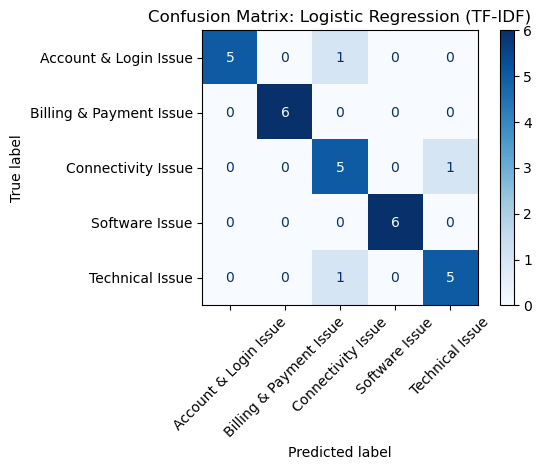


Model: Logistic Regression
Total Misclassified: 3 out of 30


,Row Index,Actual Label,Predicted Label,Complaint
0,62,Connectivity Issue,Technical Issue,App stays offline no matter what I try.
1,145,Technical Issue,Connectivity Issue,The laptop has no display output when I connec...
2,100,Account & Login Issue,Connectivity Issue,I can’t log in through Duo anymore.



→ Evaluating Model: Linear SVM


<Figure size 800x600 with 0 Axes>

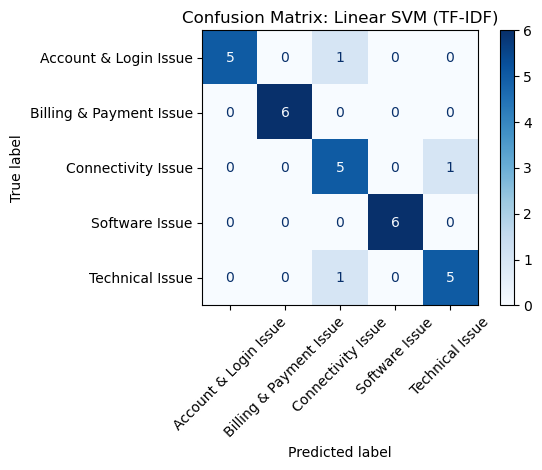


Model: Linear SVM
Total Misclassified: 3 out of 30


,Row Index,Actual Label,Predicted Label,Complaint
0,62,Connectivity Issue,Technical Issue,App stays offline no matter what I try.
1,145,Technical Issue,Connectivity Issue,The laptop has no display output when I connec...
2,100,Account & Login Issue,Connectivity Issue,I can’t log in through Duo anymore.



→ Evaluating Model: Random Forest


<Figure size 800x600 with 0 Axes>

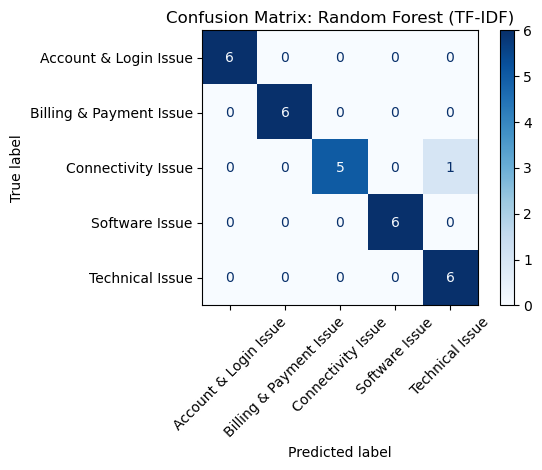


Model: Random Forest
Total Misclassified: 1 out of 30


,Row Index,Actual Label,Predicted Label,Complaint
0,62,Connectivity Issue,Technical Issue,App stays offline no matter what I try.



========================= Bag of Words RESULTS =========================

→ Evaluating Model: Logistic Regression


<Figure size 800x600 with 0 Axes>

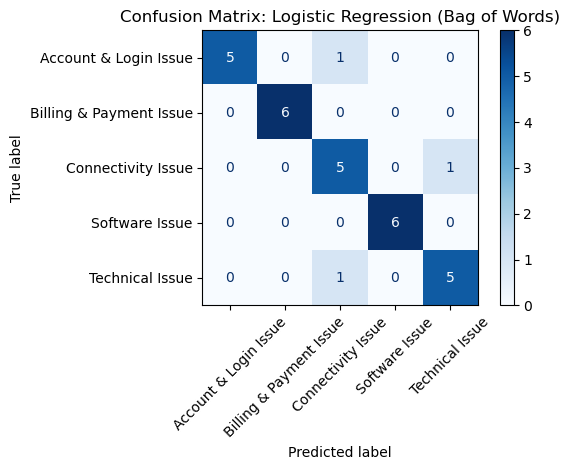


Model: Logistic Regression
Total Misclassified: 3 out of 30


,Row Index,Actual Label,Predicted Label,Complaint
0,62,Connectivity Issue,Technical Issue,App stays offline no matter what I try.
1,145,Technical Issue,Connectivity Issue,The laptop has no display output when I connec...
2,100,Account & Login Issue,Connectivity Issue,I can’t log in through Duo anymore.



→ Evaluating Model: Linear SVM


<Figure size 800x600 with 0 Axes>

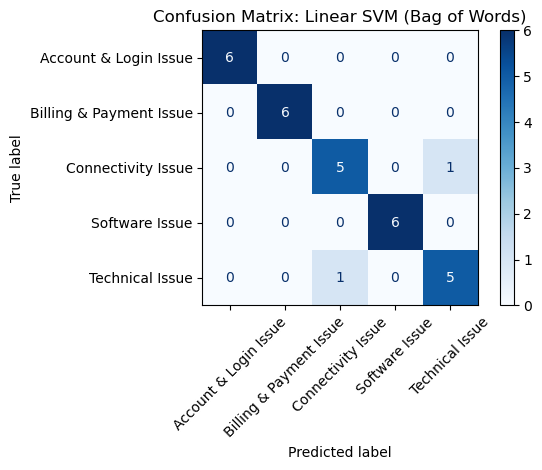


Model: Linear SVM
Total Misclassified: 2 out of 30


,Row Index,Actual Label,Predicted Label,Complaint
0,62,Connectivity Issue,Technical Issue,App stays offline no matter what I try.
1,145,Technical Issue,Connectivity Issue,The laptop has no display output when I connec...



→ Evaluating Model: Random Forest


<Figure size 800x600 with 0 Axes>

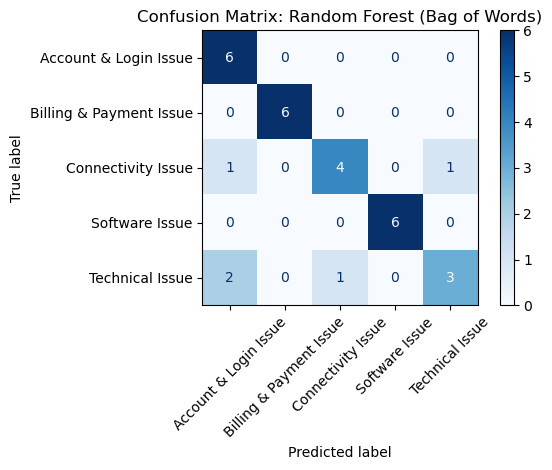


Model: Random Forest
Total Misclassified: 5 out of 30


,Row Index,Actual Label,Predicted Label,Complaint
0,62,Connectivity Issue,Technical Issue,App stays offline no matter what I try.
1,145,Technical Issue,Connectivity Issue,The laptop has no display output when I connec...
2,74,Connectivity Issue,Account & Login Issue,Offline mode appears while I’m clearly online.
3,128,Technical Issue,Account & Login Issue,I’m getting a BIOS error on startup and can’t ...
4,127,Technical Issue,Account & Login Issue,"Every time I leave it idle, it freezes and won..."


In [32]:
# Step 1: Run classification for both vectorizer types
results_tfidf = run_text_classification(X_train_tokens, X_test_tokens, y_train, y_test, vectorizer_type="tfidf")
results_bow = run_text_classification(X_train_tokens, X_test_tokens, y_train, y_test, vectorizer_type="bow")

# Step 2: Wrap both in a master dictionary
all_results = {
    "TF-IDF": results_tfidf,
    "Bag of Words": results_bow
}

# Step 3: Unified evaluation loop
for vec_name, model_results in all_results.items():
    print(f"\n{'='*25} {vec_name} RESULTS {'='*25}")

    for model_name, result_dict in model_results.items():
        model = result_dict["model"]
        test_matrix = result_dict["X_test_matrix"]

        print(f"\n→ Evaluating Model: {model_name}")

        # 1. Plot confusion matrix
        plot_confusion_matrices(
            models_dict={model_name: model},
            y_test=y_test,
            X_test_matrix=test_matrix,
            title_suffix=f"({vec_name})"
        )

        # 2. Show misclassifications
        misclassified = generate_misclassification_reports(
            models_dict={model_name: model},
            y_test=y_test,
            X_test_df=X_test_df,
            X_test_matrix=test_matrix
        )

        # 3. Save inside all_results for future access
        all_results[vec_name][model_name]["misclassified"] = misclassified


## 4.5 Misclassification Analysis
### Objective:
This allows us to analyze a single misclassified complaint to understand:
- Which words were in the complaint after preprocessing
- What TF-IDF scores those words had
- How much each word contributed to each possible class
- Why the model may have made a wrong prediction

In [42]:
def analyze_misclassified_row(row_index, model, vectorizer, preprocessed_df, X_test_df, X_test_matrix, y_test):
    """
    Analyze why a given row was misclassified by showing:
    - Original complaint and true/predicted label
    - Preprocessed tokens
    - TF-IDF scores for each token
    - Contribution of each token to every class

    Parameters:
        row_index (int): Original index of the misclassified row in preprocessed_df
        model: Trained scikit-learn linear classifier (must support .coef_)
        vectorizer: Fitted TfidfVectorizer object
        preprocessed_df (DataFrame): Full preprocessed dataset
        X_test_df (DataFrame): Test set with 'original_index' and 'Customer Statement'
        X_test_matrix (sparse matrix): TF-IDF matrix for test samples
        y_test (list or Series): True labels
    """
    import numpy as np

    # Check for linear model support
    if not hasattr(model, "coef_"):
        print(" This analysis is only supported for linear models like Logistic Regression or LinearSVC.")
        return

    # Get position of this row in the test set
    try:
        row_pos = list(X_test_df["original_index"]).index(row_index)
    except ValueError:
        print(f"Row index {row_index} not found in test set.")
        return

    original_row = preprocessed_df.loc[row_index]

    print("=" * 60)
    print(f" Analyzing Misclassified Row (Original Index: {row_index})")
    print("=" * 60)
    print(f"\n Complaint:\n\"{original_row['Customer Statement']}\"")
    print(f"\n Actual Label: {y_test.iloc[row_pos]}")
    print(f" Predicted Label: {model.predict(X_test_matrix[row_pos])[0]}")

    # Step 1: Show preprocessed tokens
    tokens = original_row["tokens"]
    print(f"\n Preprocessed Tokens:\n{tokens}")

    # Step 2: TF-IDF scores for words in this row
    tfidf_row = X_test_matrix[row_pos]
    feature_names = vectorizer.get_feature_names_out()
    
    word_scores = {
        feature_names[i]: tfidf_row.data[j]
        for j, i in enumerate(tfidf_row.indices)
    }

    sorted_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    print("\n Top TF-IDF Word Scores:")
    for word, score in sorted_scores:
        print(f"  {word:<15} : {score:.4f}")

    # Step 3: Word contributions to each class
    class_labels = model.classes_
    coef_matrix = model.coef_

    print("\n Word Contributions Toward Each Class:")
    for word, tfidf_val in sorted_scores:
        idx = vectorizer.vocabulary_.get(word)
        if idx is not None:
            print(f"\n  Word: '{word}' (TF-IDF: {tfidf_val:.4f})")
            for i, label in enumerate(class_labels):
                impact = coef_matrix[i][idx] * tfidf_val
                print(f"    {label:<20}: {impact:.4f}")


In [43]:
model = all_results["TF-IDF"]["Logistic Regression"]["model"]
vectorizer = all_results["TF-IDF"]["Logistic Regression"]["vectorizer"]
X_test_matrix = all_results["TF-IDF"]["Logistic Regression"]["X_test_matrix"]

analyze_misclassified_row(
    row_index=62,
    model=model,
    vectorizer=vectorizer,
    preprocessed_df=preprocessed_df,
    X_test_df=X_test_df,
    X_test_matrix=X_test_matrix,
    y_test=y_test
)


 Analyzing Misclassified Row (Original Index: 62)

 Complaint:
"App stays offline no matter what I try."

 Actual Label: Connectivity Issue
 Predicted Label: Technical Issue

 Preprocessed Tokens:
['app', 'stay', 'offline', 'matter', 'try']

 Top TF-IDF Word Scores:
  matter          : 0.5467
  stay            : 0.5467
  app             : 0.4485
  try             : 0.4485

 Word Contributions Toward Each Class:

  Word: 'matter' (TF-IDF: 0.5467)
    Account & Login Issue: -0.0381
    Billing & Payment Issue: -0.0296
    Connectivity Issue  : -0.0361
    Software Issue      : -0.0287
    Technical Issue     : 0.1325

  Word: 'stay' (TF-IDF: 0.5467)
    Account & Login Issue: -0.0296
    Billing & Payment Issue: -0.0319
    Connectivity Issue  : -0.0282
    Software Issue      : -0.0268
    Technical Issue     : 0.1164

  Word: 'app' (TF-IDF: 0.4485)
    Account & Login Issue: 0.1401
    Billing & Payment Issue: -0.1002
    Connectivity Issue  : 0.0425
    Software Issue      : 0.0159
  

In [38]:
def show_rf_feature_importance(row_index, model, vectorizer, preprocessed_df):
    original_row = preprocessed_df.loc[row_index]
    tokens = original_row["tokens"]
    
    print(f"\nComplaint: {original_row['Customer Statement']}")
    print(f"\nTokens: {tokens}")
    
    feature_importance = model.feature_importances_
    feature_names = vectorizer.get_feature_names_out()
    
    word_scores = {
        word: feature_importance[vectorizer.vocabulary_.get(word)]
        for word in tokens if word in vectorizer.vocabulary_
    }

    sorted_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nTop Important Words According to Random Forest:")
    for word, score in sorted_scores:
        print(f"  {word}: {score:.6f}")


In [39]:
show_rf_feature_importance(62, all_results["TF-IDF"]["Random Forest"]["model"], 
                           all_results["TF-IDF"]["Random Forest"]["vectorizer"], 
                           preprocessed_df)



Complaint: App stays offline no matter what I try.

Tokens: ['app', 'stay', 'offline', 'matter', 'try']

Top Important Words According to Random Forest:
  try: 0.005580
  app: 0.002170
  matter: 0.000959
  stay: 0.000451
